In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [14]:
# Data generation
np.random.seed(0)
torch.manual_seed(0)

# Generate x values
x = np.random.uniform(-1, 1, size=(100, 1))

# Define a smooth transition function
def smooth_transition(x, low, high):
    return 1 / (1 + np.exp(-10 * (x - (low + high) / 2)))

# Define y as a continuous piecewise linear function with smooth transitions
def generate_continuous_y(x):
    transition1 = -0.33
    transition2 = 0.33
    
    # Calculate the smooth transition weights
    w1 = smooth_transition(x, transition1, transition1)  # Smooth transition around transition1
    w2 = smooth_transition(x, transition2, transition2)  # Smooth transition around transition2
    
    # Linear functions for different regions
    y = (1 - w1) * (2 * x + 1) + w1 * ((1 - w2) * (-x + 0.5) + w2 * (0.5 * x + 1))
    
    return y

y = generate_continuous_y(x)

# Convert numpy arrays to PyTorch tensors
x_tensor = torch.tensor(x, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

In [15]:
class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.linear1 = nn.Linear(input_size, 1, bias=True)   # XB1 + B0 (bias)
        self.linear2 = nn.Linear(input_size, 1, bias=False)  # XB2
        self.linear3 = nn.Linear(input_size, 1, bias=False)  # XB3
        self.relu = nn.ReLU()  # Instantiate ReLU

    def forward(self, X):
        linear_part1 = self.linear1(X)  # XB1 + B0 (bias)
        linear_part2 = self.linear2(X)  # XB2
        linear_part3 = self.linear3(X)  # XB3
        y = linear_part1 + self.relu(linear_part2) + self.relu(linear_part3)
        return y

In [16]:
def train_model(x_tensor, y_tensor):
    model = SimpleNN(1)

    # Define loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.1)

    # Early stopping parameters
    patience = 5000
    best_loss = float('inf')
    counter = 0

    # Training loop
    num_epochs = 100000
    for epoch in range(num_epochs):
        model.train()
        
        # Forward pass
        outputs = model(x_tensor)
        loss = criterion(outputs, y_tensor)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Early stopping
        if loss.item() < best_loss:
            best_loss = loss.item()
            counter = 0  # Reset counter if the loss improves
        else:
            counter += 1
        
        if counter >= patience:
            print(f'Early stopping at epoch {epoch + 1}')
            break
    
    return model

Early stopping at epoch 5124


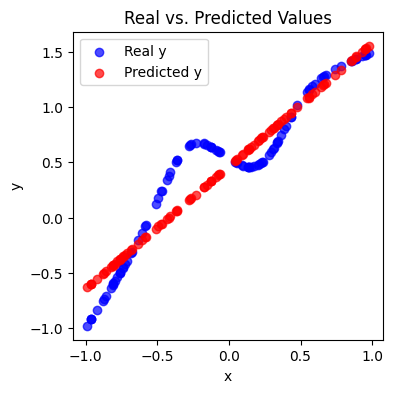

In [17]:
# Test the model
model = train_model(x_tensor, y_tensor)
model.eval()
with torch.no_grad():
    test_y = model(x_tensor).numpy()  # Convert to numpy array for plotting

# Plot the results (x1, y) and (x1, test_y)
plt.figure(figsize=(4, 4))
plt.scatter(x, y_tensor.numpy(), label='Real y', color='blue', alpha=0.7)  # Plot real y
plt.scatter(x, test_y, label='Predicted y', color='red', alpha=0.7)        # Plot predicted y
plt.xlabel('x')
plt.ylabel('y')
plt.title('Real vs. Predicted Values')
plt.legend()
plt.show()

In [18]:
# Print all parameters with names
for name, param in model.named_parameters():
    print(f"Parameter name: {name} \t Parameter value: {param.data.numpy()}")

Parameter name: linear1.weight 	 Parameter value: [[1.109352]]
Parameter name: linear1.bias 	 Parameter value: [0.46629846]
Parameter name: linear2.weight 	 Parameter value: [[0.00499797]]
Parameter name: linear3.weight 	 Parameter value: [[-0.00173512]]
